该项目是目的为了更好地服务于校园运动分析的校园空间原型的获取与处理。

机器学习：线性分类器（线性回归）/逻辑回归（soft max）/SVM(核函数)/神经网络模型/决策树/集成学习方法/聚类/马尔可夫链/

In [1]:
import scipy.cluster.vq as scv
from PIL import Image
from numpy import array
import numpy as np
from scipy import misc

import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
import itertools
import shapely
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import matplotlib.cm as cm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
from shapely.geometry import Point

In [2]:
from palettable.colorbrewer.sequential import Reds_9 
from matplotlib.colors import Normalize 

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
thu_OSM = gpd.read_file('../../202203_Campus/03_data/04_30/campus_landuse.shp') 

In [5]:
thu_OSM.head(1)

,fid,osm_id,osm_way_id,name,type,aeroway,amenity,admin_leve,barrier,boundary,...,man_made,military,natural,office,place,shop,sport,tourism,other_tags,geometry
0,1,1260420,None,None,multipolygon,None,None,None,None,None,...,None,None,water,None,None,None,None,None,None,"POLYGON ((116.31464 40.00025, 116.31442 40.000..."


接下来的任务是拆分并清洗空值，以‘aeroway’……‘other_tags’拆分为多个gdf。思路是按照空值索引将其赋予到以列为命名的组里。

In [6]:
columns_list_thu_OSM_copy = list(thu_OSM)
del columns_list_thu_OSM_copy[0:5]
del columns_list_thu_OSM_copy[-1]
columns_list_thu_OSM_copy #由 thu_OSM 的columns组成的列表

['aeroway',
 'amenity',
 'admin_leve',
 'barrier',
 'boundary',
 'building',
 'craft',
 'geological',
 'historic',
 'land_area',
 'landuse',
 'leisure',
 'man_made',
 'military',
 'natural',
 'office',
 'place',
 'shop',
 'sport',
 'tourism',
 'other_tags']

In [7]:
a = thu_OSM.columns
list_thu_copy = []
for i in columns_list_thu_OSM_copy:
    gdf = thu_OSM.dropna(subset=[i], inplace = False)
    list_thu_copy.append(gdf)
list_thu_copy[columns_list_thu_OSM_copy.index('natural')]

,fid,osm_id,osm_way_id,name,type,aeroway,amenity,admin_leve,barrier,boundary,...,man_made,military,natural,office,place,shop,sport,tourism,other_tags,geometry
0,1,1260420,None,None,multipolygon,None,None,None,None,None,...,None,None,water,None,None,None,None,None,None,"POLYGON ((116.31464 40.00025, 116.31442 40.000..."
8,41,None,33431808,None,None,None,None,None,None,None,...,None,None,wood,None,None,None,None,None,None,"POLYGON ((116.31154 40.00035, 116.31186 40.000..."
342,458,None,226683926,None,None,None,None,None,None,None,...,None,None,grassland,None,None,None,None,None,None,"POLYGON ((116.32062 40.00440, 116.32126 40.004..."
354,489,None,226936427,None,None,None,None,None,None,None,...,None,None,grassland,None,None,None,None,None,None,"POLYGON ((116.32020 40.01085, 116.32042 40.010..."
360,495,None,226936547,None,None,None,None,None,None,None,...,None,None,grassland,None,None,None,None,None,None,"POLYGON ((116.32098 40.00852, 116.32099 40.008..."
423,837,None,451335312,None,None,None,None,None,None,None,...,None,None,wood,None,None,None,None,None,None,"POLYGON ((116.31248 40.00350, 116.31296 40.003..."
431,846,None,453690518,None,None,None,None,None,None,None,...,None,None,grassland,None,None,None,None,None,None,"POLYGON ((116.31626 40.00966, 116.31653 40.009..."
464,1045,None,659826163,荷塘,None,None,None,None,None,None,...,None,None,water,None,None,None,None,None,"""water""=>""pond""","POLYGON ((116.31582 40.00224, 116.31603 40.002..."
537,1427,None,993288489,None,None,None,None,None,None,None,...,None,None,water,None,None,None,None,None,"""water""=>""river""","POLYGON ((116.31868 39.99952, 116.31949 39.999..."
553,1597,None,1013335980,光阴湖,None,None,None,None,None,None,...,None,None,water,None,None,None,None,None,"""intermittent""=>""yes"",""name:zh""=>""附中时令湖"",""salt...","POLYGON ((116.31351 40.00809, 116.31354 40.008..."


In [8]:
for i in range(1,len(columns_list_thu_OSM_copy),1):
    if not list_thu_copy[i].empty:
        list_thu_copy[i].to_file('../../202203_Campus/03_data/thu_OSM/thuOSM_' + columns_list_thu_OSM_copy[i] + '.shp')

In [9]:
thu_OSM.to_file('../../202203_Campus/03_data/thu_OSM/thuOSM' + '.shp')

以上将OSM下载的文件按照分类类型分割为各shp，之后可以直接以文件名调用需要的内容。

接下来处理将OSM信息对应到grid上的步骤，以thuOSM_natural.shp为例，thu范围为'../../202203_Campus/03_data/GIS/tsinghua.shp'
需要完成 
1.根据校园范围建立格网
2.将OSM信息根据包含面积关系赋值

In [10]:
thu = gpd.read_file('../../202203_Campus/03_data/GIS/tsinghua.shp')

In [11]:
thu.crs = {'init': 'epsg:4326'}
thu_copy = thu.to_crs({'init': 'epsg:4509'})
thu_copy.length.head()

0    7741.639636
dtype: float64

In [12]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

xmin, ymin, xmax, ymax = thu_copy.total_bounds

length = 30
wide = 30

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.to_file("../../202203_Campus/03_data/GIS/grid.shp")

In [13]:
grid.crs = {'init': 'epsg:4509'}
grid = grid.to_crs (thu.crs)

<AxesSubplot:>

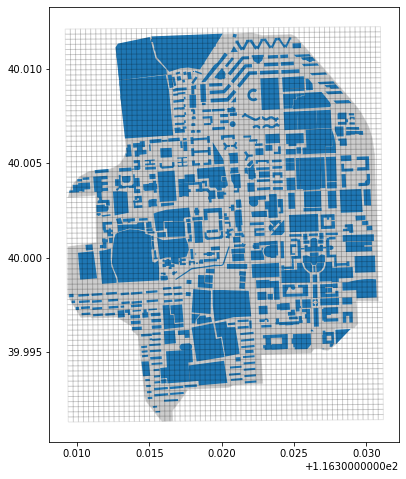

In [14]:
ax = thu.plot(figsize=(12,8),facecolor='grey', edgecolor='white', alpha=0.4)
thu_OSM.plot(ax=ax)
grid.plot(ax=ax, facecolor='None', edgecolor='black', alpha=0.1)

In [15]:
grid_copy = grid

As above, the gird of thu has been created and saved as "../../202203_Campus/03_data/GIS/grid.shp"

It will ues the overlay() function and the Double for loop to grid the OSM data.
正在进行overlap analysis……

In [16]:
i =1501
clip = gpd.overlay(thu_OSM, grid_copy[i:i+1], how='intersection')
clip

,fid,osm_id,osm_way_id,name,type,aeroway,amenity,admin_leve,barrier,boundary,...,man_made,military,natural,office,place,shop,sport,tourism,other_tags,geometry
0,243,None,105276037,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((116.31597 40.00160, 116.31596 40.001..."
1,322,None,226624816,工字厅,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,"""name:en""=>""Gong Zi Ting""","POLYGON ((116.31603 40.00187, 116.31631 40.001..."


In [17]:
clip.geometry.area.sum()

7.514618484758469e-08

<AxesSubplot:>

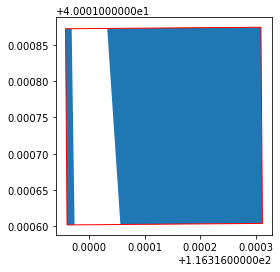

In [18]:
ax = clip.plot()
grid_copy[i:i+1].plot(ax=ax, facecolor='None', edgecolor='red')

In [19]:
# test grid cell 1500-1600:

for i in grid_copy.index[1500:1600]:
    clip = gpd.overlay(thu_OSM, grid_copy[i:i+1], how='intersection')
    if len(clip)>=1:
        grid_copy.loc[i, 'built_area'] = clip.geometry.area.sum()
        grid_copy.loc[i, 'num_bldg'] = len(clip)
    else:
        pass

In [20]:
grid_copy[1500:1600]

,geometry,built_area,num_bldg
1500,"POLYGON ((116.31596 40.00133, 116.31631 40.001...",4.036160e-08,3.0
1501,"POLYGON ((116.31596 40.00160, 116.31631 40.001...",7.514618e-08,2.0
1502,"POLYGON ((116.31596 40.00187, 116.31631 40.001...",1.432237e-07,3.0
1503,"POLYGON ((116.31595 40.00214, 116.31631 40.002...",1.177939e-07,2.0
1504,"POLYGON ((116.31595 40.00241, 116.31630 40.002...",3.841233e-08,1.0
...,...,...,...
1595,"POLYGON ((116.31627 40.00620, 116.31662 40.006...",3.980166e-08,2.0
1596,"POLYGON ((116.31626 40.00647, 116.31661 40.006...",1.386279e-07,2.0
1597,"POLYGON ((116.31626 40.00674, 116.31661 40.006...",1.317377e-07,2.0
1598,"POLYGON ((116.31626 40.00701, 116.31661 40.007...",9.385789e-08,3.0


In [21]:
def is_na(value):
    if pd.isna(value) and value != "" and value != "nan":
        return True
    else:
        return False

In [22]:
# calculate the intersection of the grid and OSMdata:

grid_copy_test = grid 
for i in grid_copy.index:
    clip = gpd.overlay(thu_OSM, grid_copy[i:i+1], how='intersection')
    if len(clip)>=1:
        for j in clip.index:
            for k in clip.columns[6:26]:
                if is_na(clip.loc[j,k]) == False:
                    grid_copy_test.loc[i,k+'_area'] = clip.loc[j,'geometry'].area / grid_copy_test.loc[i,'geometry'].area
                else:
                    pass
        grid_copy_test.loc[i, 'OSM_area'] = clip.geometry.area.sum()/ grid_copy_test.loc[i,'geometry'].area
        grid_copy_test.loc[i, 'num_bldg'] = len(clip)
    else:
        pass

In [23]:
grid_copy_test.head(1)

,geometry,built_area,num_bldg,building_area,OSM_area,other_tags_area,landuse_area,leisure_area,natural_area,tourism_area,amenity_area,sport_area,place_area,shop_area,office_area,barrier_area,man_made_area
0,"POLYGON ((116.30939 39.99130, 116.30974 39.991...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
grid_copy_test.to_file('../../202203_Campus/03_data/GIS/campus_landuse_grid.shp')

Text(0, 0.5, 'Sample Density')

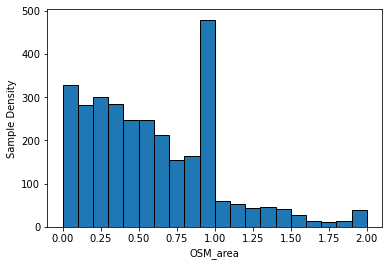

In [25]:
# 以上已写通 OSM —— grid 赋值路径
# 接下来尝试根据OSM_area的数据进行箱线图绘制与空间渐变色的可视化

grid_copy_test.OSM_area.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('OSM_area')
plt.ylabel('Sample Density')

<AxesSubplot:>

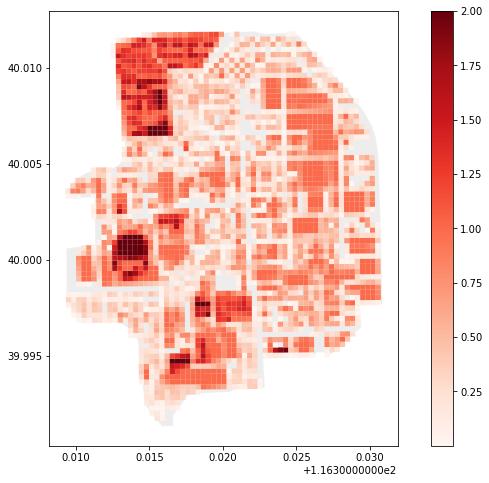

In [26]:
import matplotlib.pyplot as plt
ax = thu.plot(figsize=(12,8),facecolor='lightgrey', edgecolor='white', alpha=0.4)
grid_copy_test.plot(ax=ax, column = 'OSM_area', cmap=Reds_9.mpl_colormap, legend=True)

# grid_copy_test.plot(  # dataframe数据
#     column = 'OSM_area',  # 根据该属性渲染图形
#     cmap=Reds_9.mpl_colormap,  # palettable调色盘中颜色
#     ax=ax,
#     edgecolor='lightgrey',  # 边颜色
#     linewidth=0.5,
#     scheme='UserDefined',  # 分层设色 用户自定义
#     classification_kwds={'bins': [3, 6, 24, 35, 48]},

#    #此处norm是关键，它将颜色控制与图例颜色匹配
#     norm=Normalize(0, len(bins))
# )

In [27]:
# 接下来根据grid对keep数据进行分析，需要做2步
# 提取并切割与grid相关的数据集。
# grid与路径做交集分析

In [28]:
df = grid_copy_test[grid_copy_test.OSM_area>=0.2]